## Import Libaries 

In [1]:
from ultralytics import YOLO

import torch
import matplotlib.pyplot as plt
import numpy as np 
import cv2

## Use trained model to predict

In [2]:
# Load model
model = YOLO("./runs/segment/train4/weights/best.pt")

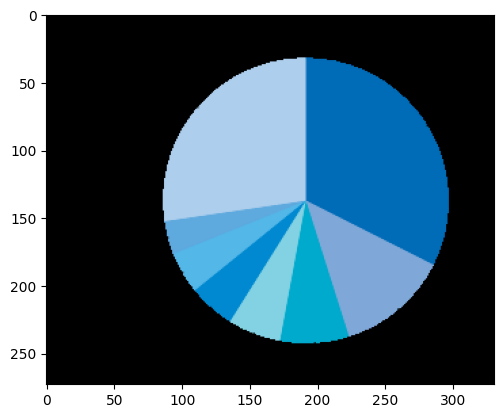

In [3]:
img_path = "../../assets/dataset/test/piedata(1008)/pie/images/test2019/f447ffede2ef85e73a191f8c1ed3f9df_c3RhdGxpbmtzLm9lY2Rjb2RlLm9yZwk5Mi4yNDMuMjMuMTM3.XLS-0-0.png"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [4]:
# Test model 
results = model(img_path)[0]
results.save("output.png")


image 1/1 /media/vietz/Data5/FPT/2025/SPRING/DPL302m/ASSIGNMENTS_AND_EXAMS/PROJECTS/ChartInsight/testing/segmentation/../../assets/dataset/test/piedata(1008)/pie/images/test2019/f447ffede2ef85e73a191f8c1ed3f9df_c3RhdGxpbmtzLm9lY2Rjb2RlLm9yZwk5Mi4yNDMuMjMuMTM3.XLS-0-0.png: 544x640 8 Seriess, 44.4ms
Speed: 3.4ms preprocess, 44.4ms inference, 112.8ms postprocess per image at shape (1, 3, 544, 640)


'output.png'

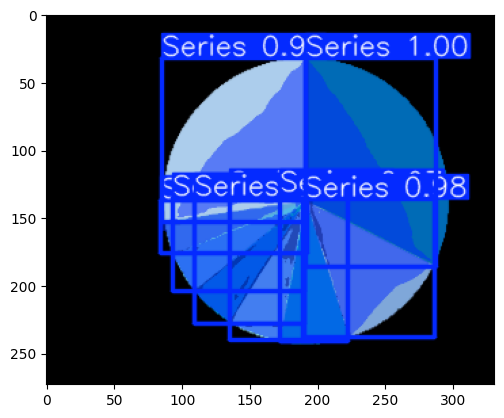

In [5]:
# Display results
res = cv2.imread("output.png")
res = cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

plt.imshow(res)

## Extract value from result

`result.masks` are segments in result

In [6]:
masks = results.masks.data

# Convert masks to numpy
masks = masks.cpu().numpy()
masks

array([[[          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        ...,
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0]],

       [[          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        ...,
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,        

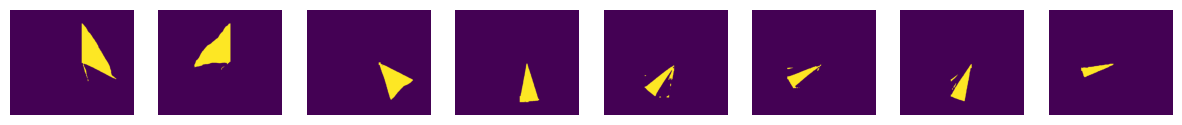

In [7]:
fig, ax = plt.subplots(1, len(masks), figsize = (15, 15))
ax = ax.flatten()
for i, mask in enumerate(masks):
    ax[i].imshow(mask)
    ax[i].axis("off")
plt.show()

### Contours (from mask)

In [8]:
from scipy.spatial.distance import pdist, squareform, cdist

In [9]:
first_mask = masks[0]

# convert mask to binary
binary_mask = (first_mask > 0).astype(np.uint8) * 255

# find contour -> take the largest one ->  squeeze to 2D
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour = max(contours, key=cv2.contourArea)
contour = contour.squeeze()
contour

array([[370,  74],
       [370, 276],
       [374, 276],
       [376, 278],
       [376, 279],
       [377, 280],
       [377, 291],
       [378, 292],
       [378, 293],
       [380, 295],
       [380, 298],
       [381, 299],
       [381, 303],
       [382, 304],
       [382, 306],
       [383, 307],
       [383, 309],
       [384, 310],
       [384, 313],
       [385, 314],
       [385, 319],
       [386, 320],
       [386, 322],
       [388, 324],
       [388, 326],
       [389, 327],
       [389, 329],
       [390, 330],
       [390, 331],
       [392, 333],
       [392, 334],
       [393, 335],
       [393, 341],
       [394, 342],
       [394, 344],
       [395, 344],
       [396, 345],
       [396, 346],
       [397, 347],
       [397, 352],
       [398, 353],
       [398, 354],
       [399, 353],
       [399, 349],
       [398, 348],
       [398, 345],
       [397, 344],
       [397, 343],
       [396, 342],
       [396, 340],
       [395, 339],
       [395, 336],
       [394,

In [10]:
dist_matrix = squareform(pdist(contour))

# take 2 farthest points
idx1, idx2 = np.unravel_index(dist_matrix.argmax(), dist_matrix.shape)

# the third point is the farthest point to the closest point between point1 and point2
idx3 = np.argmax(np.min(dist_matrix[[idx1, idx2]], axis = 0))

keypoints = contour[[idx1, idx2, idx3]]
keypoints

array([[370,  74],
       [547, 359],
       [370, 276]], dtype=int32)

In [11]:
#add the first point to the end to make a closed loop
keypoints_closed = np.vstack([keypoints, keypoints[0]])

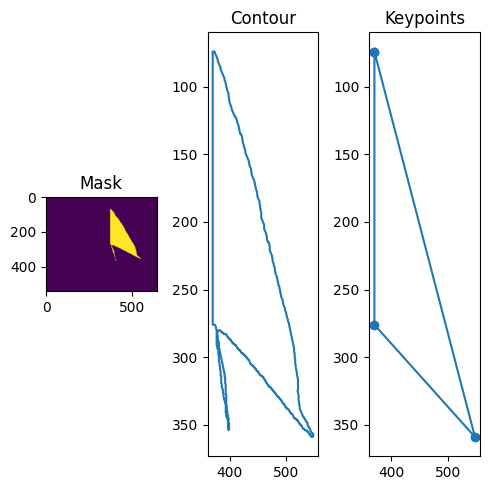

In [12]:
fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (5, 5))
ax[0].imshow(binary_mask)
ax[0].set_title("Mask")

ax[1].plot(contour[:, 0], contour[:, 1])
ax[1].invert_yaxis()
ax[1].set_title("Contour")

ax[2].plot(keypoints_closed[:, 0], keypoints_closed[:, 1], 'o-')
ax[2].invert_yaxis()
ax[2].set_title("Keypoints")

plt.tight_layout()
plt.show()

### 3 keypoints

The expected 3 keypoints of each mask are `[(x1, y1), (x2, y2), (xc, yc)]` for arc points and center point

In [13]:
def get_keypoint(mask: np.ndarray) -> np.ndarray : 
    """
    Get 3 keypoint from mask by finding the 2 farthest points and the farthest point to the closest point between the 2 farthest points

    Args:
        mask (np.ndarray): mask in masks result from YOLO segmentation

    Returns:
        np.ndarray: 3 keypoints
    """
    binary_mask = (mask > 0).astype(np.uint8) * 255
    
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key=cv2.contourArea)
    contour = contour.squeeze()
    
    dist_matrix = squareform(pdist(contour))
    
    idx1, idx2 = np.unravel_index(dist_matrix.argmax(), dist_matrix.shape)
    idx3 = np.argmax(np.min(dist_matrix[[idx1, idx2]], axis = 0))
    
    keypoints = contour[[idx1, idx2, idx3]]
    
    return keypoints

In [14]:
keypoint = get_keypoint(first_mask)
keypoint

array([[370,  74],
       [547, 359],
       [370, 276]], dtype=int32)

In [15]:
def get_keypoints(masks: np.ndarray) -> np.ndarray:
    """
    Get keypoints of triangle from masks, each keypoint box format [x1, y1, x2, y2, xc, yc] (can be shuflled but keep the x, y order)
    Args:
        masks (np.ndarray): masks result from YOLO segmentation

    Returns:
        np.ndarray: shape (n, 6) with n is the number of mask segmented
    """
    keypoints = np.array([get_keypoint(mask) for mask in masks])

    return keypoints

In [16]:
keypoints = get_keypoints(masks)
keypoints

array([[[370,  74],
        [547, 359],
        [370, 276]],

       [[185, 297],
        [373,  74],
        [373, 270]],

       [[370, 274],
        [434, 465],
        [545, 362]],

       [[370, 279],
        [334, 477],
        [407, 388]],

       [[210, 404],
        [361, 289],
        [306, 375]],

       [[182, 359],
        [357, 286],
        [280, 346]],

       [[262, 449],
        [369, 283],
        [348, 387]],

       [[166, 316],
        [333, 282],
        [253, 319]]], dtype=int32)

In [17]:
masks.shape

(8, 544, 640)

In [18]:
kps = np.array([get_keypoint(mask) for mask in masks])
kps.shape

(8, 3, 2)

In [19]:
print(kps)

[[[370  74]
  [547 359]
  [370 276]]

 [[185 297]
  [373  74]
  [373 270]]

 [[370 274]
  [434 465]
  [545 362]]

 [[370 279]
  [334 477]
  [407 388]]

 [[210 404]
  [361 289]
  [306 375]]

 [[182 359]
  [357 286]
  [280 346]]

 [[262 449]
  [369 283]
  [348 387]]

 [[166 316]
  [333 282]
  [253 319]]]


In [20]:
t1, t2 = kps[0], kps[1]
distances = cdist(t1, t2, metric = "euclidean")
distances

array([[     289.75,           3,      196.02],
       [     367.27,      333.92,      195.44],
       [     186.19,      202.02,      6.7082]])

In [21]:
_ = distances.ravel()

# get the position of the first and second smallest
pos1, pos2 = np.argsort(_)[:2]

# unravel it to get the index of the points
idx1 = np.unravel_index(pos1, distances.shape)
idx2 = np.unravel_index(pos2, distances.shape)
idx1, idx2

((0, 1), (2, 2))

In [22]:
idx1_x, idx1_y = idx1
pairs1 = t1[idx1_x], t2[idx1_y]

idx2_x, idx2_y = idx2
pairs2 = t1[idx2_x], t2[idx2_y]


pairs1, pairs2

((array([370,  74], dtype=int32), array([373,  74], dtype=int32)),
 (array([370, 276], dtype=int32), array([373, 270], dtype=int32)))

In [23]:
# compair with the third triangle to find the closest point
t3 = kps[2]
distances = cdist(t3, np.vstack([pairs1, pairs2]), metric = "euclidean")
distances

array([[        200,      200.02,           2,           5],
       [      396.2,      395.73,      199.54,      204.32],
       [        337,      335.45,      194.99,      195.06]])

In [24]:
idx = np.unravel_index(distances.argmin(), distances.shape)
idx

(0, 2)

In [25]:
point = t3[idx[0]]
point

array([370, 274], dtype=int32)

In [26]:
# find the closest points to point in the remain triangle
for i in range(3, kps.shape[0]):
    t = kps[i]
    distances = cdist(t, point.reshape(1, -1), metric = "euclidean")
    idx = np.unravel_index(distances.argmin(), distances.shape)
    point = t[idx[0]]
    print(point)

[370 279]
[361 289]
[357 286]
[369 283]
[333 282]


In [27]:
kps[-1]

array([[166, 316],
       [333, 282],
       [253, 319]], dtype=int32)

In [28]:
def get_triangle_flag(keypoints: np.ndarray) -> np.ndarray:
    """
    Get the boolean flag of the points in the triangle whether it is the center or not 
    Args:
        keypoints (np.ndarray): keypoints of the triangle
    Returns:
        np.ndarray: shape (n, 3) with n is the number of keypoints, 3 is the number of points in the triangle
    """    
    if masks.shape[0] >= 3: 
        t1, t2, t3 = keypoints[:3]
        
        # find the 2 closest pairs of t1 and t2
        dis_12 = cdist(t1, t2, metric = "euclidean")
        
        _ = dis_12.ravel()

        # get the position of the first and second smallest
        pos1, pos2 = np.argsort(_)[:2]

        # unravel it to get the index of the points
        idx1 = np.unravel_index(pos1, dis_12.shape)
        idx2 = np.unravel_index(pos2, dis_12.shape)
        
        # get the pairs
        idx1_x, idx1_y = idx1
        pairs1 = t1[idx1_x], t2[idx1_y]

        idx2_x, idx2_y = idx2
        pairs2 = t1[idx2_x], t2[idx2_y]        
        
        # compare with the third triangle to find the closest point
        dis_3 = cdist(t3, np.vstack([pairs1, pairs2]), metric = "euclidean")
        idx = np.unravel_index(dis_3.argmin(), dis_3.shape)
        
        # IT IS THE CENTER!!!!
        point = t3[idx[0]]
        
    flag = np.zeros((keypoints.shape[0], 3))
    for i in range(keypoints.shape[0]):
        t = keypoints[i]
        dis = cdist(t, point.reshape(1, -1), metric = "euclidean")
        idx = np.unravel_index(dis.argmin(), dis.shape)
        flag[i, idx[0]] = 1
    
    return flag

In [29]:
flag = get_triangle_flag(kps)
flag

array([[          0,           0,           1],
       [          0,           0,           1],
       [          1,           0,           0],
       [          1,           0,           0],
       [          0,           1,           0],
       [          0,           1,           0],
       [          0,           1,           0],
       [          0,           1,           0]])

In [30]:
def get_bboxs(masks: np.ndarray) -> np.ndarray:
    """
    Get the bounding box of the masks, each bbox format [x1, y1, x2, y2, xc, yc]
    Args:
        masks (np.ndarray): masks result from YOLO segmentation

    Returns:
        np.ndarray: shape (n, 3, 2) with n is the number of mask segmented
    """
    keypoints = get_keypoints(masks)
    flag = get_triangle_flag(keypoints)

    sorted_triangles = np.array(
        [tri[np.argsort(f)] for tri, f in zip(keypoints, flag)]  # flag 1 go end
    )

    return sorted_triangles

In [31]:
bboxs = get_bboxs(masks)
bboxs

array([[[370,  74],
        [547, 359],
        [370, 276]],

       [[185, 297],
        [373,  74],
        [373, 270]],

       [[434, 465],
        [545, 362],
        [370, 274]],

       [[334, 477],
        [407, 388],
        [370, 279]],

       [[210, 404],
        [306, 375],
        [361, 289]],

       [[182, 359],
        [280, 346],
        [357, 286]],

       [[262, 449],
        [348, 387],
        [369, 283]],

       [[166, 316],
        [253, 319],
        [333, 282]]], dtype=int32)

### Angles (from 3 keypoints)

$$
\theta = \cos^{-1} \left( \frac{\mathbf{u} \cdot \mathbf{v}}{\|\mathbf{u}\| \|\mathbf{v}\|} \right)
$$

In [32]:
def get_angle(bbox: np.ndarray) -> np.ndarray:
    """
    Get the angle BAC of the triangle bounding box in degree
    Args:
        bbox (np.ndarray): bounding box of the mask, format [xA, yA, xB, yB, xc, yc]

    Returns:
        np.ndarray: angle of the bounding box
    """

    vector_CA = bbox[2] - bbox[0]
    vector_CB = bbox[2] - bbox[1]
    
    dot_product = np.dot(vector_CA, vector_CB)
    
    norm_CA = np.linalg.norm(vector_CA)
    norm_CB = np.linalg.norm(vector_CB)
    
    cos_theta = dot_product / (norm_CA * norm_CB)
    angle = np.arccos(cos_theta)
    
    return np.degrees(angle)

In [33]:
angles = [get_angle(bbox) for bbox in bboxs]
angles

[115.1231278053967,
 98.17276487755451,
 44.779241740514266,
 29.05460409907714,
 20.107152149274736,
 15.283353654332908,
 21.389110813694305,
 13.31281063857623]

In [34]:
sum(angles)

357.2221657784208

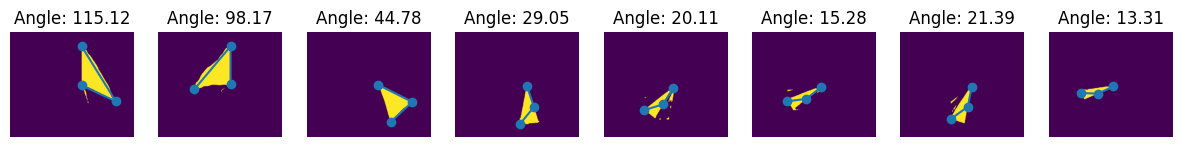

In [35]:
fig, ax = plt.subplots(1, len(masks), figsize = (15, 15))
ax = ax.flatten()
for i, mask in enumerate(masks):
    ax[i].imshow(mask)
    ax[i].plot(bboxs[i][:, 0], bboxs[i][:, 1], 'o-')
    ax[i].set_title(f"Angle: {angles[i]:.2f}")
    ax[i].axis("off")

plt.show()

In [36]:
def get_percent(bbox: np.ndarray) -> np.ndarray:
    """
    Get the percent of the arc in the pie chart.
    Args:
        bbox (np.ndarray): bounding box of the mask, format [xA, yA, xB, yB, xc, yc]

    Returns:
        np.ndarray: percent of the bounding box
    """
    angles = np.array([get_angle(b) for b in bbox])
    percent = angles / angles.sum()
    return percent

In [37]:
percents = get_percent(bboxs)
percents

array([    0.32227,     0.27482,     0.12535,    0.081335,    0.056288,    0.042784,    0.059876,    0.037268])

In [42]:
percents = np.array([    0.32227,     0.12535,    0.081335,    0.056288,    0.042784,    0.059876,    0.037268,      0.27482])
percents

array([    0.32227,     0.12535,    0.081335,    0.056288,    0.042784,    0.059876,    0.037268,     0.27482])

## Result

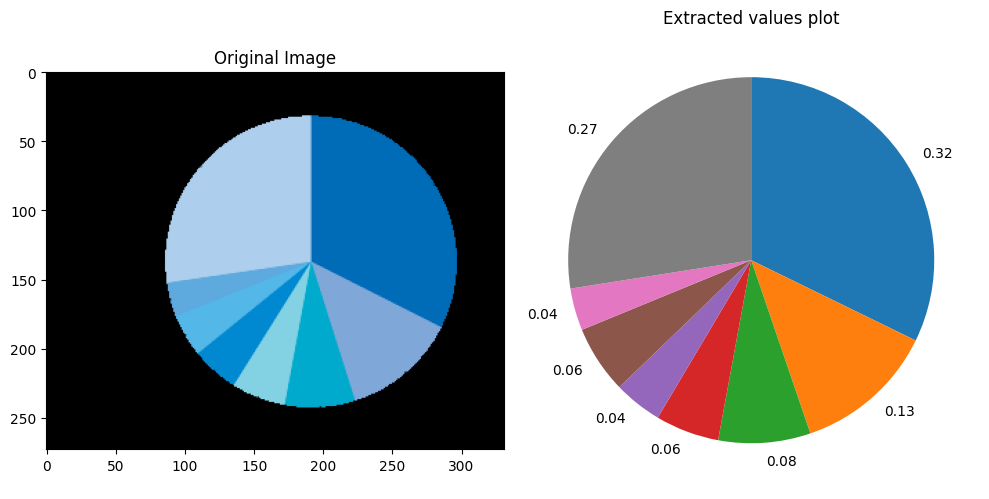

In [ ]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (10, 5))

ax[0].imshow(img)
ax[0].set_title("Original Image")

ax[1].pie(percents, labels=[f"{p:.2f}" for p in percents], startangle=90, counterclock=False)
ax[1].set_title("Extracted values plot")

plt.tight_layout()
plt.show()

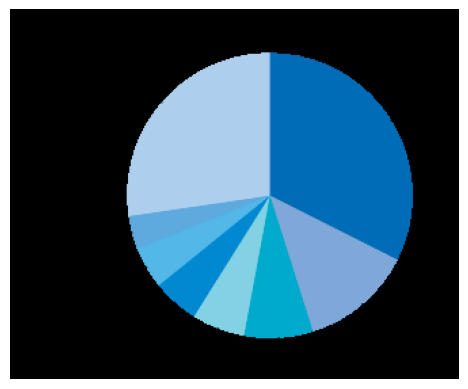

In [47]:
plt.figure()
plt.imshow(img)
plt.axis("off")
plt.show()

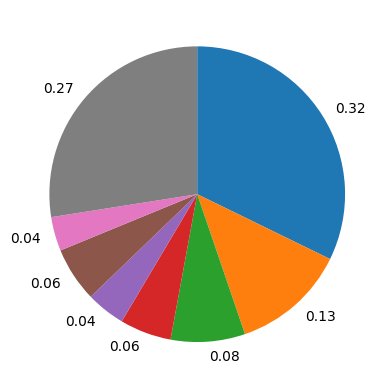

In [45]:
plt.figure()
plt.pie(percents, labels=[f"{p:.2f}" for p in percents], startangle=90, counterclock=False)
plt.show()

In [49]:
import pandas as pd

In [55]:
df = pd.DataFrame(percents, columns = ["percent"])
df["series"] = df.index
df = df[["series", "percent"]]
df

,series,percent
0,0,0.322270
1,1,0.125350
2,2,0.081335
3,3,0.056288
4,4,0.042784
5,5,0.059876
6,6,0.037268
7,7,0.274820
